In [1]:
!nvidia-smi

Tue Jan 12 19:42:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install gdown
!pip install tensorflow-gpu

     |████████████████████████████████| 394.7MB 40kB/s 


## Import Libraries

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## Load and Inspect the NIFTY50 Index Data

In [4]:
df = pd.read_csv('/content/NIFTY50.csv', parse_dates=['date'], index_col='date')

In [5]:
df.head()

,close
date,
1994-01-03,1083.74
1994-01-04,1091.81
1994-01-05,1082.80
1994-01-06,1098.91
1994-01-07,1146.31


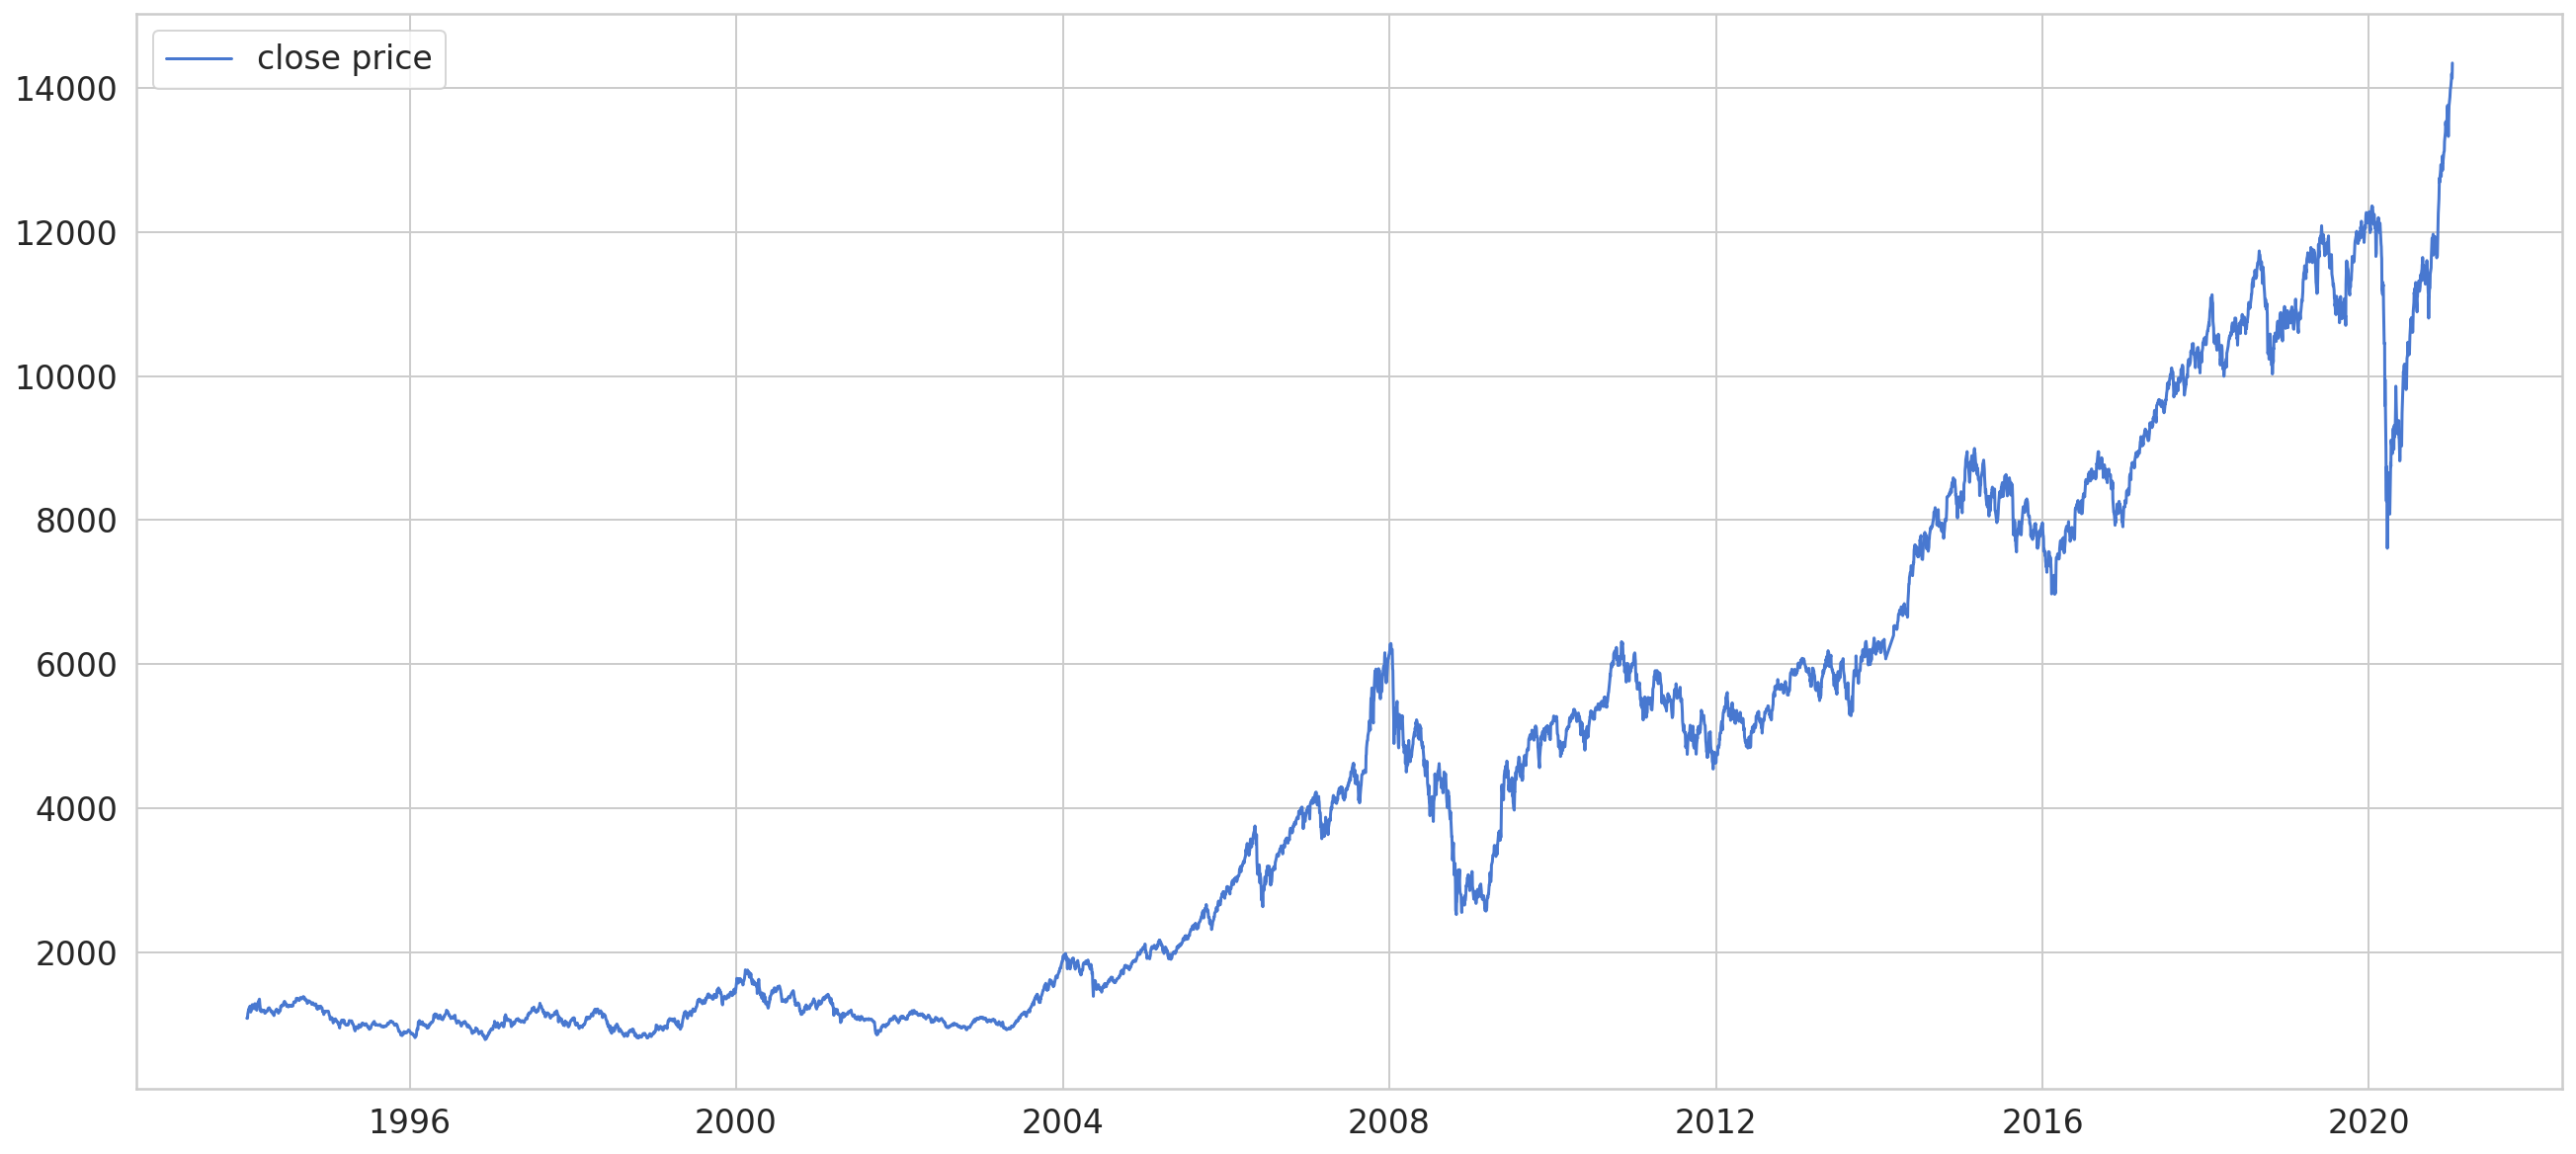

In [6]:
plt.plot(df, label='close price')
plt.legend();

## Data Preprocessing

In [7]:
train_size = int(len(df) * 0.90)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(6003, 1) (667, 1)


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


## Create Training and Test Splits

In [9]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [10]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)

(5973, 30, 1)


## Build an LSTM Autoencoder

In [11]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

## Train the Autoencoder

In [12]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    shuffle=False
)

Epoch 1/10
38/38 [==============================] - 6s 84ms/step - loss: 0.3979 - val_loss: 0.3159
Epoch 2/10
38/38 [==============================] - 2s 63ms/step - loss: 0.1587 - val_loss: 0.3083
Epoch 3/10
38/38 [==============================] - 2s 62ms/step - loss: 0.1150 - val_loss: 0.1429
Epoch 4/10
38/38 [==============================] - 2s 61ms/step - loss: 0.1085 - val_loss: 0.1986
Epoch 5/10
38/38 [==============================] - 2s 61ms/step - loss: 0.1957 - val_loss: 0.1555
Epoch 6/10
38/38 [==============================] - 2s 63ms/step - loss: 0.0940 - val_loss: 0.1431
Epoch 7/10
38/38 [==============================] - 2s 62ms/step - loss: 0.1148 - val_loss: 0.1158
Epoch 8/10
38/38 [==============================] - 2s 60ms/step - loss: 0.1166 - val_loss: 0.0955
Epoch 9/10
38/38 [==============================] - 2s 60ms/step - loss: 0.1170 - val_loss: 0.1010
Epoch 10/10
38/38 [==============================] - 2s 61ms/step - loss: 0.1133 - val_loss: 0.0984


## Plot Metrics and Evaluate the Model

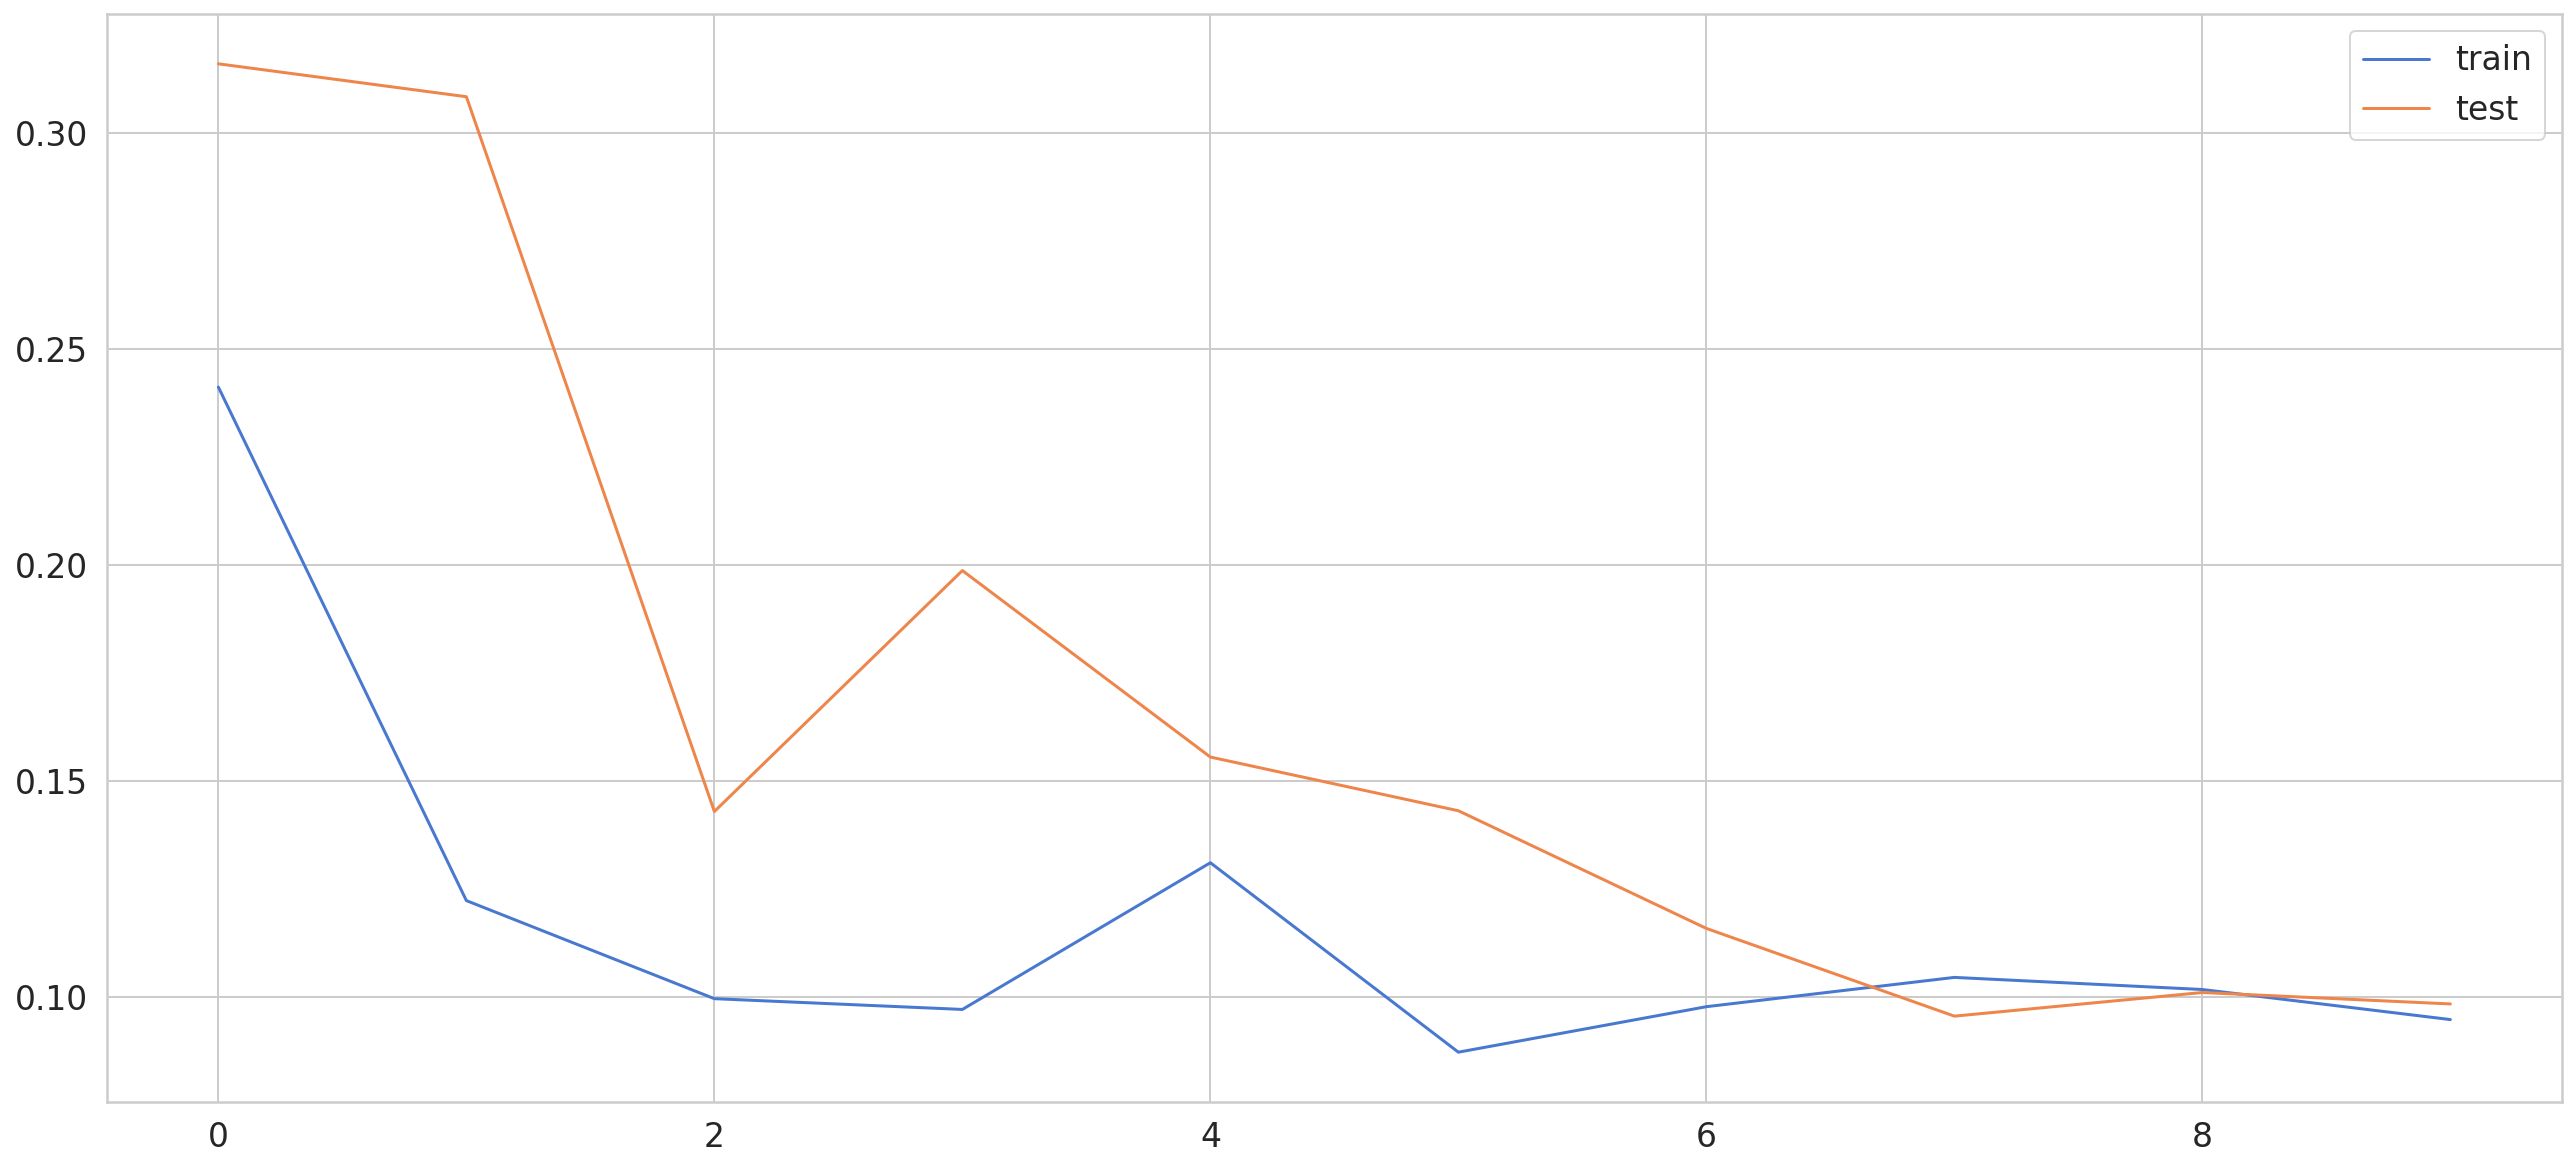

In [13]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [14]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


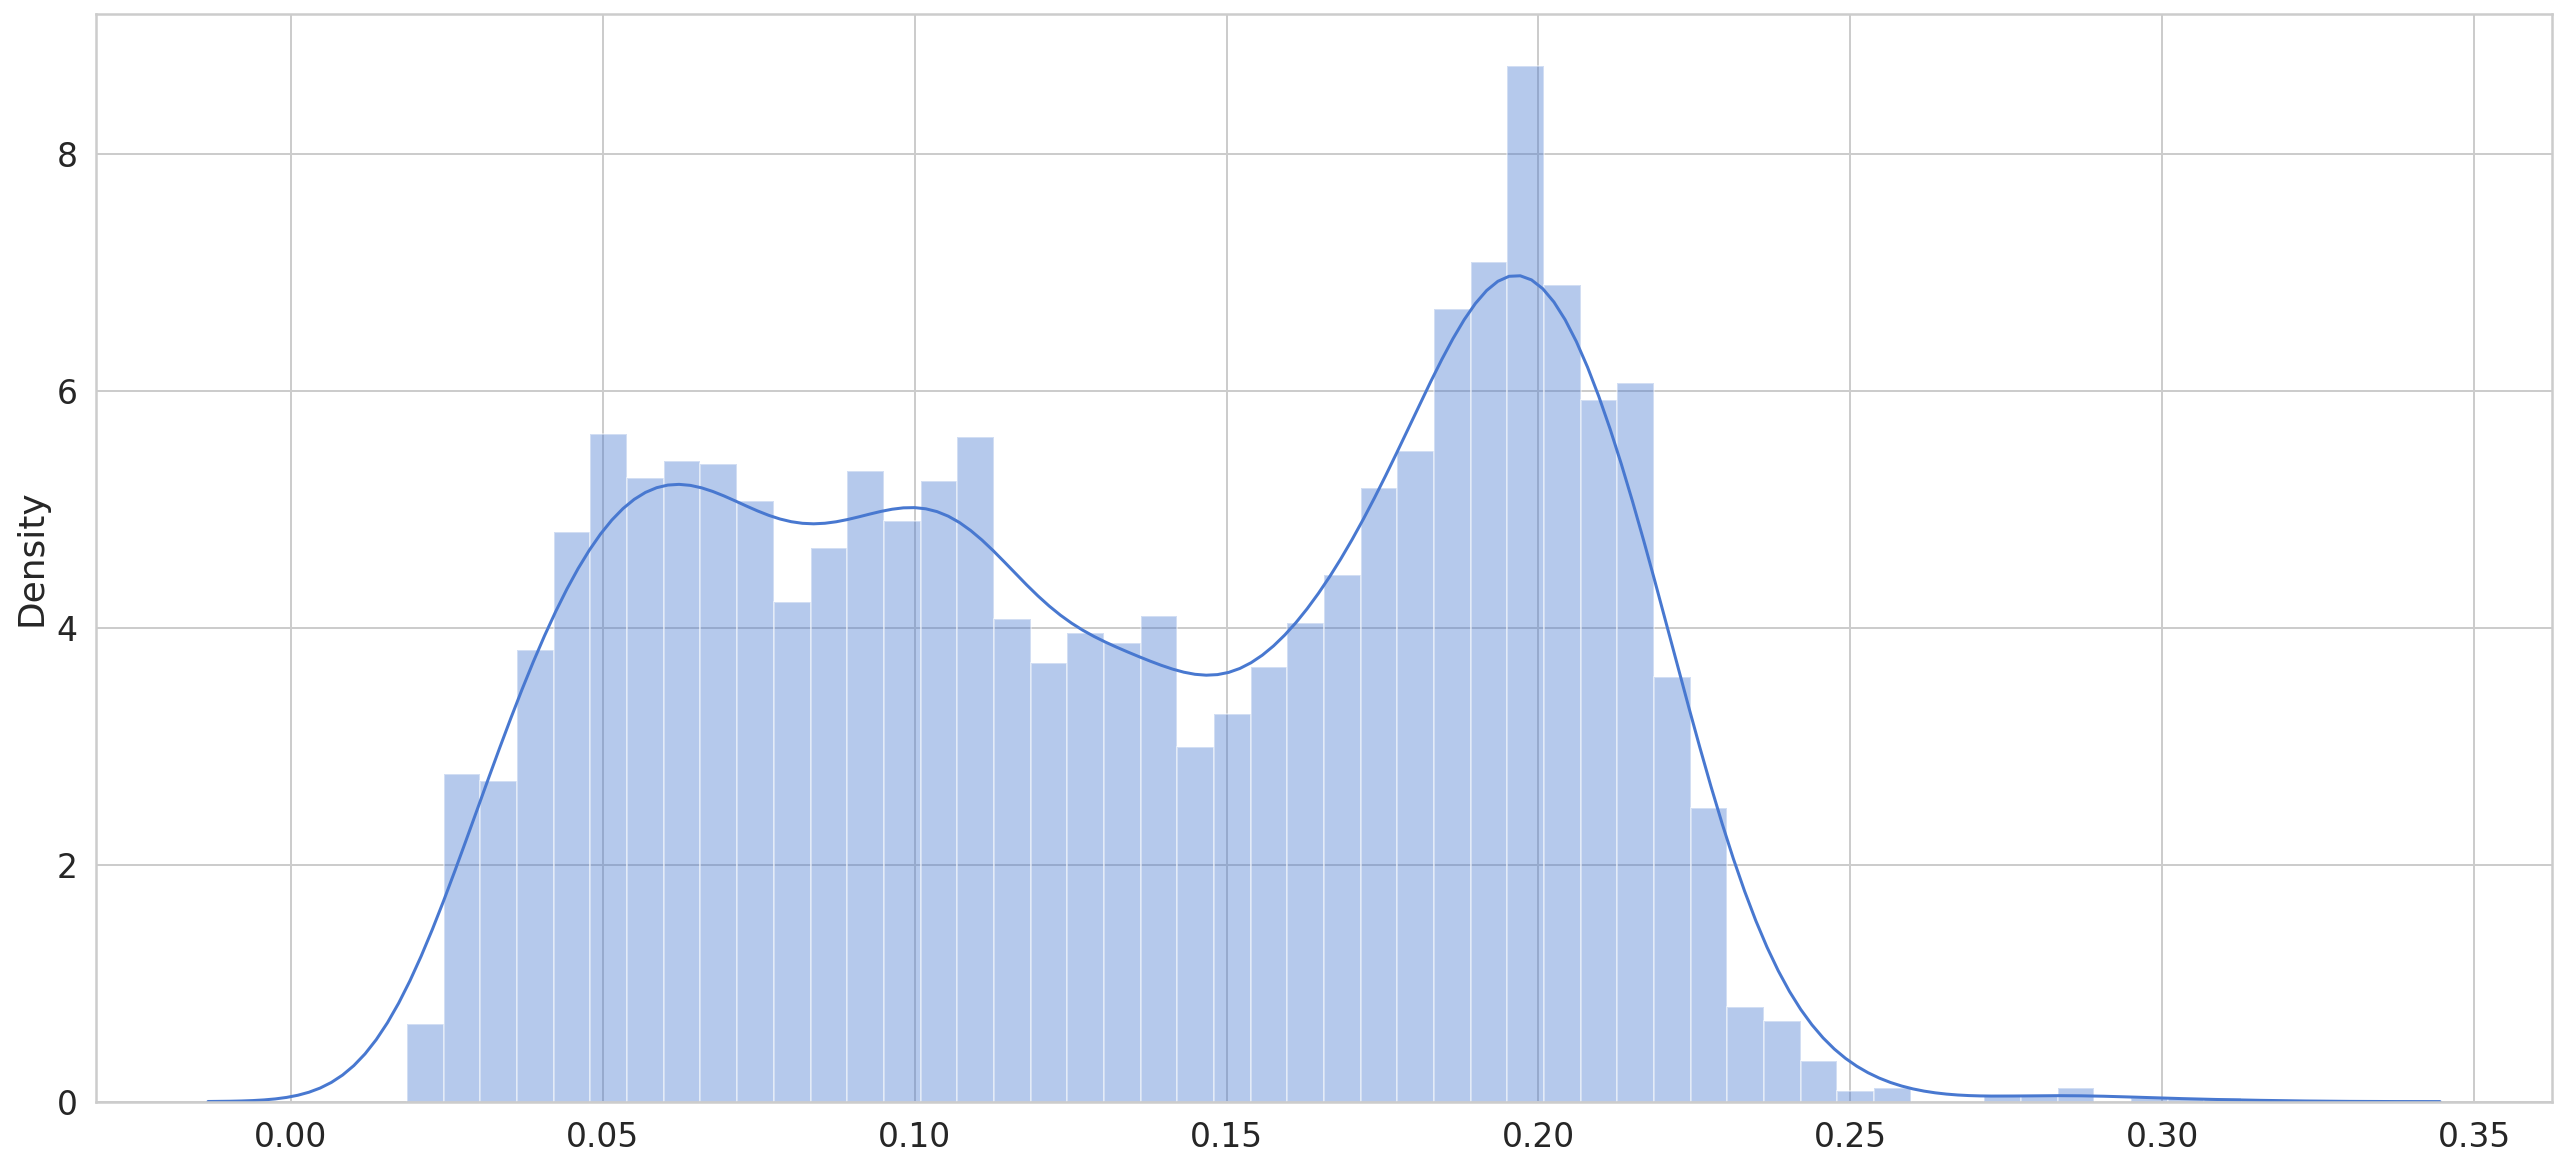

In [15]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [16]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)


## Detect Anomalies in the NIFTY50 Index Data

In [25]:
THRESHOLD = 0.33

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

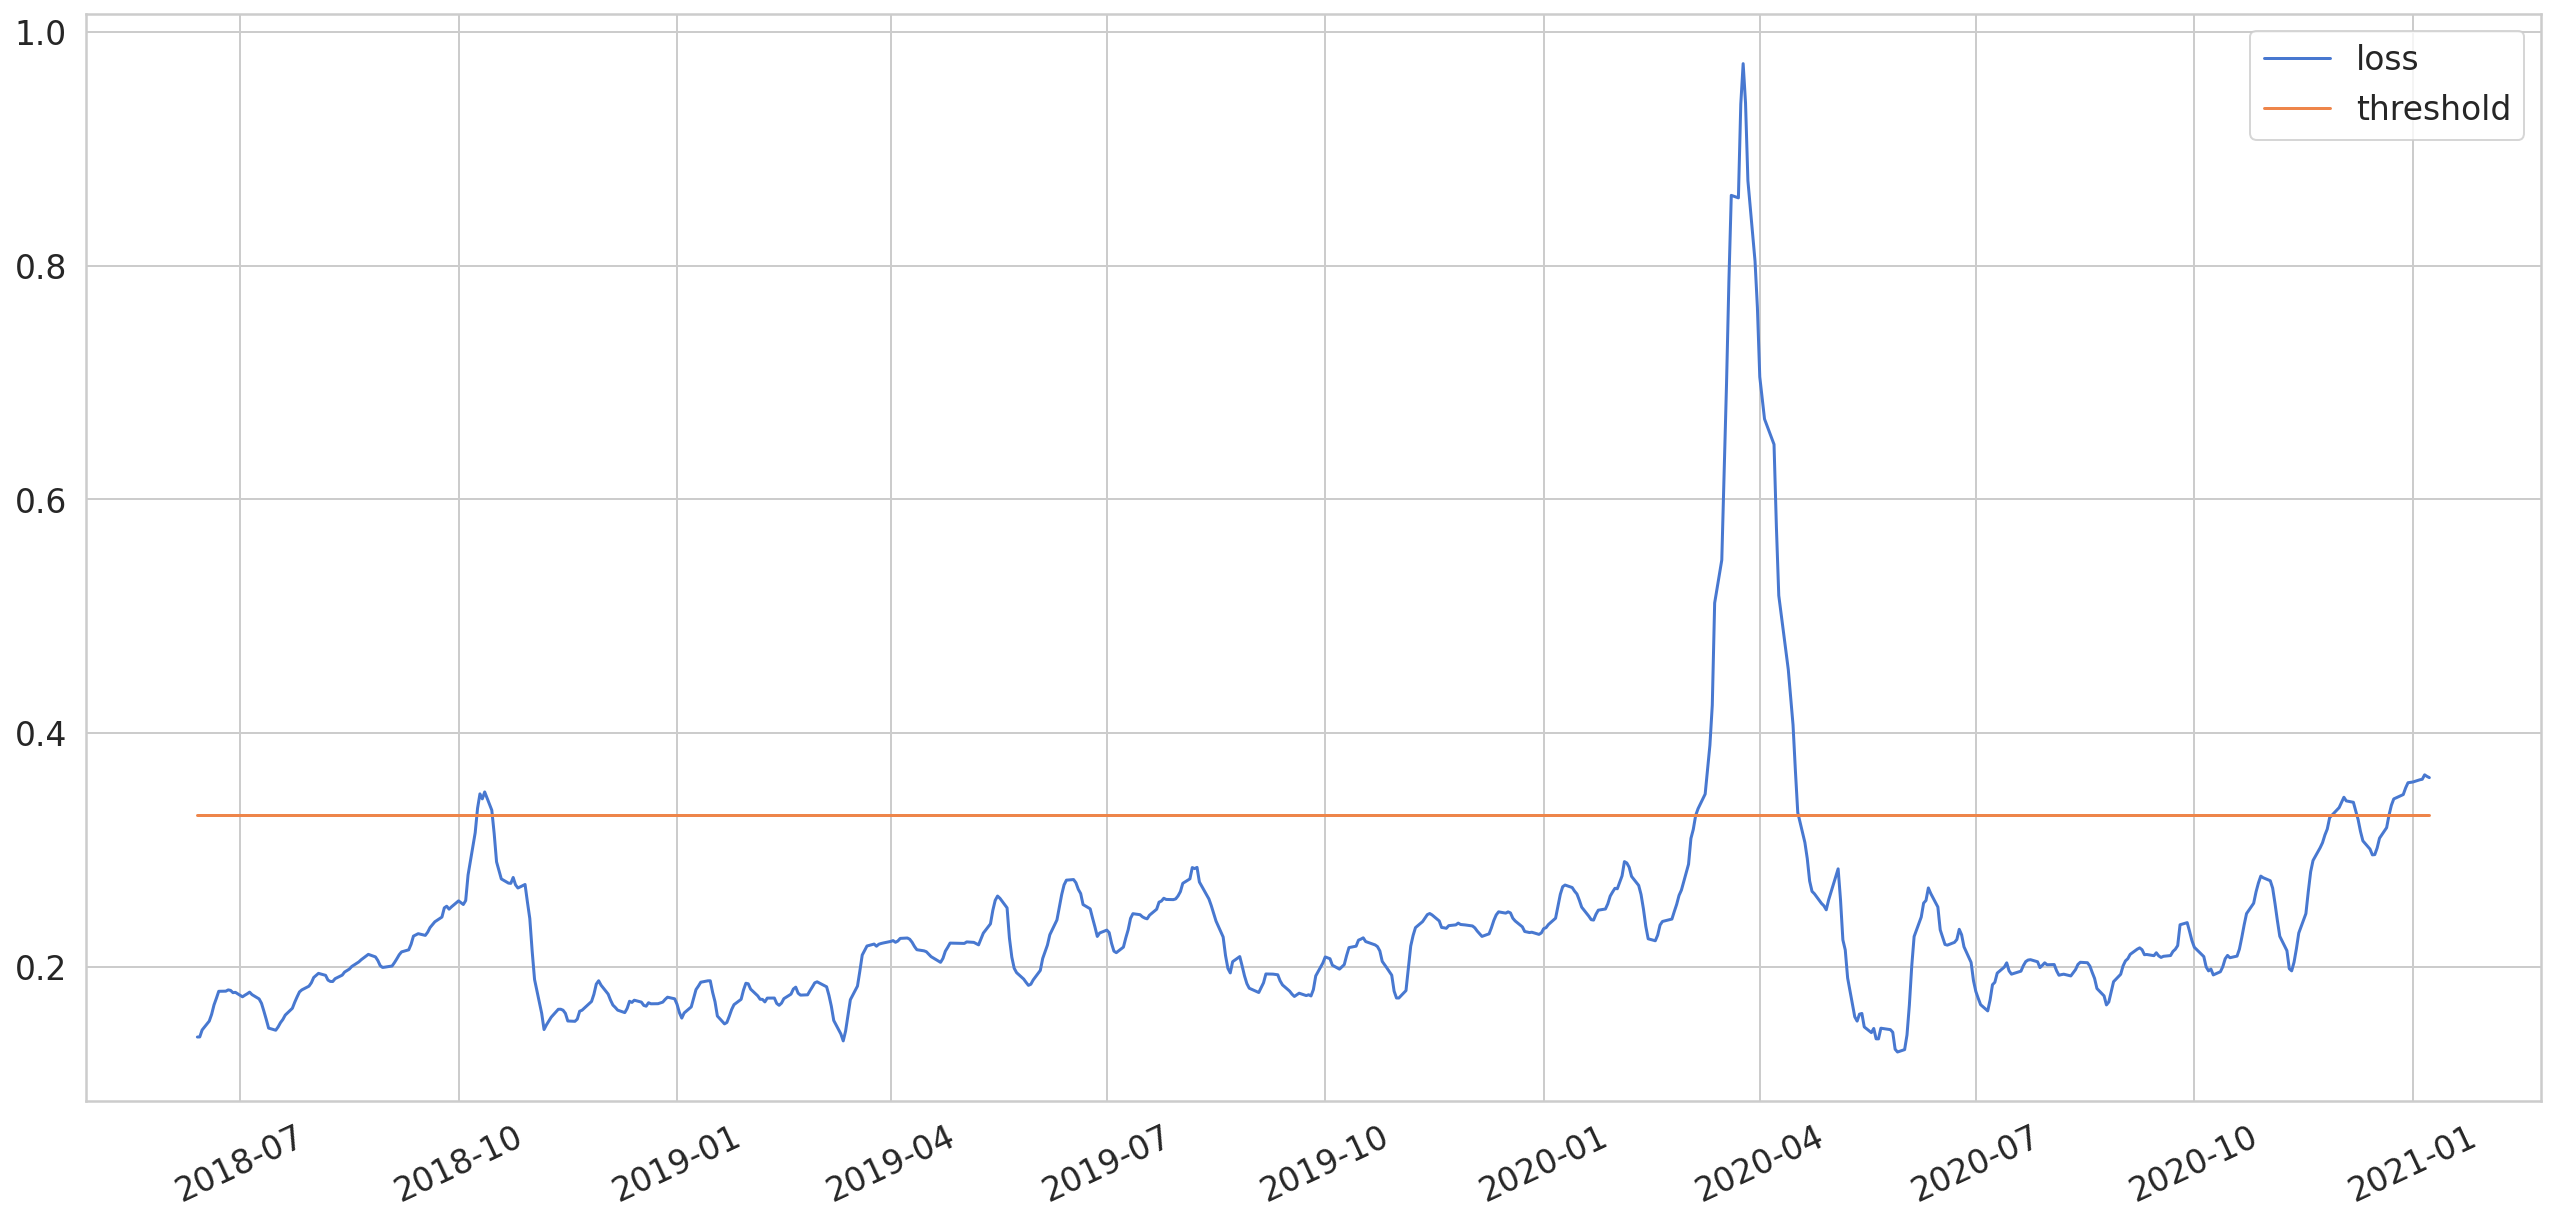

In [26]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [27]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies

,loss,threshold,anomaly,close
date,,,,
2018-10-09,0.335637,0.33,True,2.327843
2018-10-10,0.347920,0.33,True,2.384065
2018-10-11,0.343641,0.33,True,2.304372
2018-10-12,0.349578,0.33,True,2.388448
2018-10-15,0.333935,0.33,True,2.402588
2020-03-06,0.335212,0.33,True,2.571183
2020-03-09,0.347767,0.33,True,2.381007
2020-03-11,0.389610,0.33,True,2.383464
2020-03-12,0.423904,0.33,True,2.076550


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


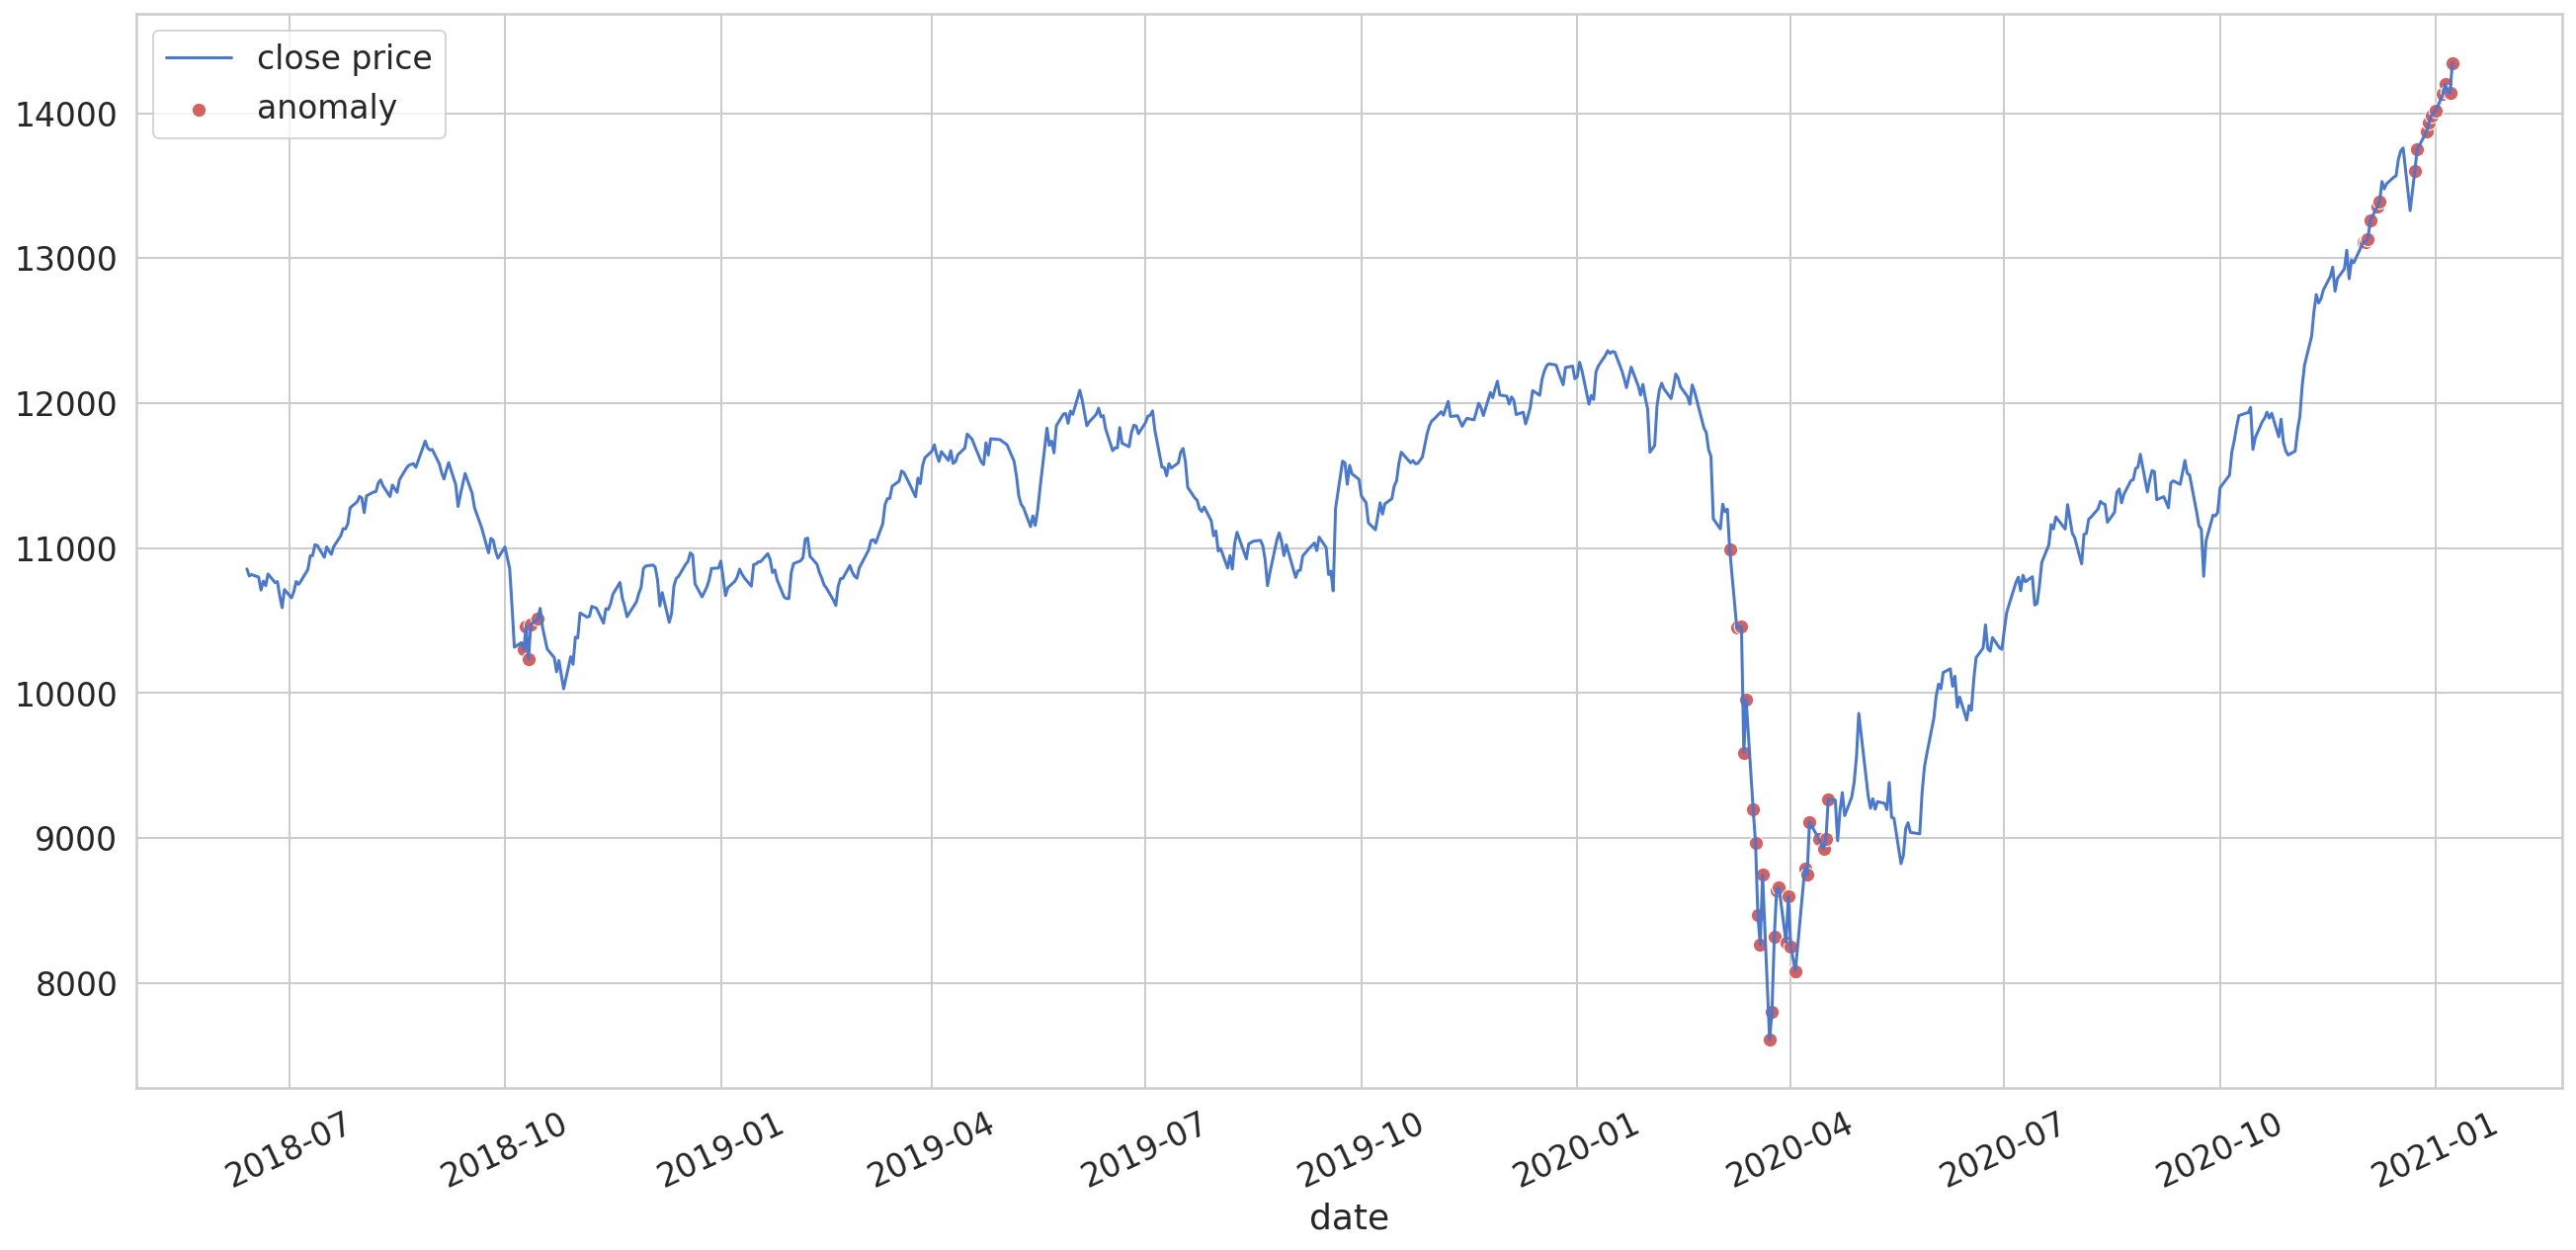

In [28]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close), 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.close),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();